In [1]:
# library import
import pandas as pd
import csv
import numpy as np
import time
import scipy
import warnings
import matplotlib.pyplot as plt


In [2]:
# remove features which are text, id, and labels 
def filter_csv_header(csv_file_path, strings_to_remove):
    with open(csv_file_path, mode='r', encoding='utf-8') as file:
        reader = csv.reader(file)
        header = next(reader)
        filtered_header = [column for column in header if column not in strings_to_remove]
    return filtered_header

text_features = ["title", "overview", "tagline", "production_companies"]
label_features = ["id", "rate_category", "average_rate"]

features_without_text = filter_csv_header("/Users/felikskong/Desktop/IML/A2/A2-Data_files/TMDB_evaluate.csv", text_features + label_features)
print(len(features_without_text))
print(features_without_text)

37
['release_year', 'runtime', 'budget', 'revenue', 'adult', 'original_language', 'popularity', 'genre_Action', 'genre_Adventure', 'genre_Animation', 'genre_Comedy', 'genre_Crime', 'genre_Documentary', 'genre_Drama', 'genre_Family', 'genre_Fantasy', 'genre_History', 'genre_Horror', 'genre_Music', 'genre_Mystery', 'genre_Romance', 'genre_Science Fiction', 'genre_TV Movie', 'genre_Thriller', 'genre_War', 'genre_Western', 'product_of_Canada', 'product_of_France', 'product_of_Germany', 'product_of_India', 'product_of_Italy', 'product_of_Japan', 'product_of_Spain', 'product_of_UK', 'product_of_USA', 'product_of_other_countries', 'vote_count']


In [3]:
# read the three data sets
train = pd.read_csv("A2-Data_files/TMDB_train.csv")
evaluate = pd.read_csv("A2-Data_files/TMDB_evaluate.csv")
test = pd.read_csv("A2-Data_files/TMDB_test.csv")

In [4]:
# since some languages may not exist across three data sets, concatenate all the original_language columns
from sklearn.preprocessing import LabelEncoder
all_languages = pd.concat([train["original_language"], evaluate["original_language"], test["original_language"]])
label_encoder = LabelEncoder()
label_encoder.fit(all_languages)
print(len(label_encoder.classes_))
train['original_language'] = label_encoder.transform(train['original_language'])
evaluate['original_language'] = label_encoder.transform(evaluate['original_language'])
test['original_language'] = label_encoder.transform(test['original_language'])


132


In [5]:
# define a function to test accuracy for different models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

accuracy_list = [[],[],[],[],[]]

def test_models(x_train, y_train, x_evaluate, y_evaluate, feature_attribute):
    model_names = ["KNN", "MNB", "DT", "LR", "MLP"]
    model_instances = [
        KNeighborsClassifier(),
        MultinomialNB(),
        DecisionTreeClassifier(),
        LogisticRegression(solver='saga', max_iter=500, n_jobs=-1, verbose=0),
        MLPClassifier()
    ]
    warnings.filterwarnings("ignore", category=UserWarning, module='sklearn')
    print("Results of ", feature_attribute)
    for i in range(len(model_names)):
        start = time.time()
        model = model_instances[i]
        model.fit(x_train, y_train)
        acc = model.score(x_evaluate, y_evaluate)
        acc = np.array(acc)
        end = time.time()
        elapsed_time = end - start
        accuracy_list[i].append(acc.round(5))
        print(f"Time used: {elapsed_time:.3f} seconds, {model_names[i]} accuracy: {acc:.5f}")

In [7]:
# data preparation

# 37 features eliminating text features
X_train_without_text = train[features_without_text]
X_evaluate_without_text = evaluate[features_without_text]
# 1000 text features using bow
X_train_text_bow = scipy.sparse.load_npz('A2-Data_files/TMDB_text_features_bow/train_concat_bow.npz')
X_evaluate_text_bow = scipy.sparse.load_npz('A2-Data_files/TMDB_text_features_bow/eval_concat_bow.npz')
# 1000 text features using tfidf
X_train_text_tfidf = scipy.sparse.load_npz('A2-Data_files/TMDB_text_features_tfidf/train_concat_tfidf.npz')
X_evaluate_text_tfidf = scipy.sparse.load_npz('A2-Data_files/TMDB_text_features_tfidf/eval_concat_tfidf.npz')
# combine text and non-text features
X_train_all_bow = np.concatenate((X_train_without_text.to_numpy(), X_train_text_bow.toarray()), axis=1)
X_evaluate_all_bow = np.concatenate((X_evaluate_without_text.to_numpy(), X_evaluate_text_bow.toarray()), axis=1)
X_train_all_tfidf = np.concatenate((X_train_without_text.to_numpy(), X_train_text_tfidf.toarray()), axis=1)
X_evaluate_all_tfidf = np.concatenate((X_evaluate_without_text.to_numpy(), X_evaluate_text_tfidf.toarray()), axis=1)
# use rate-category us label
y_train_category = train['rate_category']
y_evaluate_category = evaluate['rate_category']

print(X_train_without_text.shape)
print(X_train_text_bow.shape)
print(X_train_text_tfidf.shape)
print(X_train_all_bow.shape)
print(X_train_all_tfidf.shape)

(100000, 37)
(100000, 1000)
(100000, 1000)
(100000, 1037)
(100000, 1037)


In [13]:
# use Zero R as accuracy baseline
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score

zeroR = DummyClassifier(strategy="most_frequent")
zeroR.fit(X_train_without_text, y_train_category)

predictions = zeroR.predict(X_evaluate_without_text)
accuracy = accuracy_score(predictions, y_evaluate_category)
print("Zero Rule baseline", accuracy)

# from sklearn.metrics import classification_report
# reports = []
# reports.append(classification_report(predictions, y_evaluate_category, digits=4))
# reports.append(classification_report(predictions, y_evaluate_category, digits=4))

# print(reports[0])
# print(reports[1])


Zero Rule baseline 0.271


In [8]:
test_models(X_train_without_text, y_train_category, X_evaluate_without_text, y_evaluate_category, "features_without_text")

Results of  features_without_text
Time used: 1.306 seconds, KNN accuracy: 0.41820
Time used: 0.052 seconds, MNB accuracy: 0.11720
Time used: 0.725 seconds, DT accuracy: 0.65630
Time used: 33.575 seconds, LR accuracy: 0.26220
Time used: 57.377 seconds, MLP accuracy: 0.32450


In [9]:
test_models(X_train_text_bow, y_train_category, X_evaluate_text_bow, y_evaluate_category, "features_text_bow")

Results of  features_text_bow
Time used: 59.416 seconds, KNN accuracy: 0.34355
Time used: 0.032 seconds, MNB accuracy: 0.27645
Time used: 28.430 seconds, DT accuracy: 0.61655
Time used: 32.274 seconds, LR accuracy: 0.30620
Time used: 88.815 seconds, MLP accuracy: 0.56855


In [10]:
test_models(X_train_text_tfidf, y_train_category, X_evaluate_text_tfidf, y_evaluate_category, "features_text_tfidf")

Results of  features_text_tfidf
Time used: 58.682 seconds, KNN accuracy: 0.35675
Time used: 0.022 seconds, MNB accuracy: 0.29590
Time used: 35.972 seconds, DT accuracy: 0.61510
Time used: 1.690 seconds, LR accuracy: 0.30620
Time used: 87.022 seconds, MLP accuracy: 0.56065


In [11]:
test_models(X_train_all_bow, y_train_category, X_evaluate_all_bow, y_evaluate_category, "features_all_bow")

Results of  features_all_bow
Time used: 16.194 seconds, KNN accuracy: 0.40265
Time used: 2.391 seconds, MNB accuracy: 0.11720
Time used: 10.926 seconds, DT accuracy: 0.66365
Time used: 896.666 seconds, LR accuracy: 0.26220
Time used: 312.340 seconds, MLP accuracy: 0.36730


In [12]:
test_models(X_train_all_tfidf, y_train_category, X_evaluate_all_tfidf, y_evaluate_category, "features_all_tfidf")

Results of  features_all_tfidf
Time used: 17.602 seconds, KNN accuracy: 0.41730
Time used: 3.524 seconds, MNB accuracy: 0.11720
Time used: 16.773 seconds, DT accuracy: 0.65560
Time used: 902.892 seconds, LR accuracy: 0.26220
Time used: 175.107 seconds, MLP accuracy: 0.35320


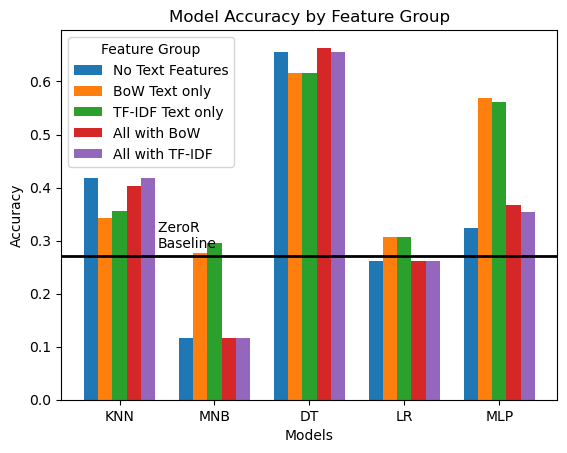

In [13]:
# accuracy_list = [[0.41820,0.34355,0.35675,0.40265,0.41730],
#                  [0.11720,0.27645,0.29590,0.11720,0.11720],
#                  [0.65685,0.61810,0.61435,0.66030,0.65485],
#                  [0.26220,0.30625,0.30615,0.26220,0.26220],
#                  [0.33600,0.57395,0.55865,0.37820,0.36140]]

model_names = ['KNN', 'MNB', 'DT', 'LR', 'MLP']
feature_groups = ['No Text Features', 'BoW Text only', 'TF-IDF Text only', 'All with BoW', 'All with TF-IDF']

num_models = len(accuracy_list)
x = np.arange(num_models)
width = 0.15

fig, ax = plt.subplots()
for i in range(len(accuracy_list[0])):
    feature_group_acc = [model[i] for model in accuracy_list]
    ax.bar(x + i*width, feature_group_acc, width=width, label=feature_groups[i])

ax.axhline(y=0.271, color='black', linestyle='-', linewidth=2)
ax.text(0.7, 0.28, 'ZeroR \nBaseline', verticalalignment='bottom', color='black')

ax.set_ylabel('Accuracy')
ax.set_xlabel('Models')
ax.set_title('Model Accuracy by Feature Group')
ax.set_xticks(x + width * 2)
ax.set_xticklabels(model_names)
ax.legend(title="Feature Group")

plt.show()

In [14]:
# # predict test set
# X_test_without_text = test[features_without_text]

# dt = DecisionTreeClassifier()
# dt.fit(X_train_without_text, y_train_category)
# y_pred_test = dt.predict(X_test_without_text)

# assert test.shape[0] == len(y_pred_test)

# test["rate_category"] = y_pred_test

# test_out = test[["id", "rate_category"]]
# test_out.to_csv('test_predictions.csv', index=False)

In [15]:
# # predict test set
# from sklearn.ensemble import RandomForestClassifier

# noise_features = ['genre_Western','product_of_India','product_of_Japan'] 
# features = filter_csv_header("/Users/felikskong/Desktop/IML/A2/A2-Data_files/TMDB_evaluate.csv", text_features + label_features + noise_features)

# X_test_without_text = test[features_without_text]

# # dt = DecisionTreeClassifier()
# # dt.fit(X_train_without_text, y_train_category)
# # y_pred_test = dt.predict(X_test_without_text)

# rf = RandomForestClassifier()
# rf.fit(X_train_without_text, y_train_category)
# y_pred_test = rf.predict(X_test_without_text)

# assert test.shape[0] == len(y_pred_test)

# test["rate_category"] = y_pred_test

# test_out = test[["id", "rate_category"]]
# test_out.to_csv('test_predictions.csv', index=False)